In [3]:
import pandas as pd
import numpy as np
from plotnine import *

%matplotlib inline

In [4]:
data = pd.read_csv("../../data/processed/expensas_full_processed_vis.csv",
                  dtype = {
                                "expensa_id": "object",
                                "unidad_id": "object",
                                "consorcio_id": "object",
                                "expensa_mes":"object",
                            },
                  parse_dates = ["expensa_fecha", "expensa_mes_pago", "expensa_mes_pago_anterior"])

In [7]:
pagos_por_unidad = pd.pivot(data, index="unidad_id", columns = "expensa_mes_pago", values = "pago_metodo")

In [118]:
_,total_meses = pagos_por_unidad.shape
meses = pagos_por_unidad.columns
lag = 3
dfs = list()

columns = []
for l in range(0, lag):
        columns.append("pago_metodo_lag_{}".format(l+1))
columns.reverse()
columns.append("target")
for i in range(0, total_meses-lag):
    filtered  = pagos_por_unidad.iloc[:, i: i+lag+1]
    filtered["cantidad_na"] = filtered.isna().sum(axis=1)/lag
    filtered = filtered.loc[filtered.cantidad_na < 0.5] 
    filtered = filtered.drop(columns="cantidad_na")
    filtered["expensa_mes_pago"] = meses[i+lag]
    filtered = filtered.reset_index()
    filtered = filtered.set_index(["unidad_id","expensa_mes_pago"])
    filtered.columns = columns
    filtered = filtered.fillna("NS/NC")
    dfs.append(filtered)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [119]:
pagos_por_unidad_lag_6 = pd.concat(dfs, sort=False)

In [120]:
pagos_por_unidad_lag_6.shape

(150663, 4)

In [121]:
pagos_por_unidad_lag_6 = pagos_por_unidad_lag_6[pagos_por_unidad_lag_6.target != "NS/NC"]

In [122]:
pagos_por_unidad_lag_6.target = (pagos_por_unidad_lag_6.target == "Impago")

In [123]:
pagos_por_unidad_lag_6 = pagos_por_unidad_lag_6.reset_index()

In [124]:
pagos_test = pagos_por_unidad_lag_6.loc[pagos_por_unidad_lag_6.expensa_mes_pago >= "2018-09-01"]
pagos_train = pagos_por_unidad_lag_6.loc[pagos_por_unidad_lag_6.expensa_mes_pago < "2018-09-01"]

In [125]:
X_train = pagos_train.drop(columns=["unidad_id","expensa_mes_pago", "target"])
Y_train = pagos_train.target
X_test = pagos_test.drop(columns=["unidad_id","expensa_mes_pago", "target"])
Y_test = pagos_test.target

In [126]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(128508, 3) (128508,)
(21777, 3) (21777,)


In [127]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
drop_test_columns = [column for column in X_test.columns if column not in X_train.columns]
X_test = X_test.drop(columns=drop_test_columns)

for column in [column for column in X_train.columns if column not in X_test.columns]:
    X_test[column] = 0

X_test = X_test[X_train.columns]

In [128]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(128508, 16) (128508,)
(21777, 16) (21777,)


In [129]:
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression(
    C = 1000000,
    solver = "lbfgs",
    penalty = "l2",
    max_iter = 100,
)
logReg.fit(X_train, Y_train) 

LogisticRegression(C=1000000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [130]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def get_train_test_meassures(model, X_train, Y_train, X_test, Y_test):
    train_preds = model.predict(X_train)
    print("accuracy:", accuracy_score(Y_train, train_preds))
    print("precision:", precision_score(Y_train, train_preds))
    print("recall:", recall_score(Y_train, train_preds))
    print("f1:", f1_score(Y_train, train_preds))
    print("--------------------------------------------------")
    test_preds = model.predict(X_test)
    print("accuracy:", accuracy_score(Y_test, test_preds))
    print("precision:", precision_score(Y_test, test_preds))
    print("recall:", recall_score(Y_test, test_preds))
    print("f1:", f1_score(Y_test, test_preds))

In [131]:
get_train_test_meassures(logReg, X_train, Y_train, X_test, Y_test)

accuracy: 0.8758987767298534
precision: 0.7990839596168112
recall: 0.7182326848925868
f1: 0.7565042139978014
--------------------------------------------------
accuracy: 0.8928686228589796
precision: 0.781799379524302
recall: 0.6700642588078883
f1: 0.7216322634530485


In [132]:
def get_logReg_coef(model, columns):
    lm_coef = pd.DataFrame({
        "variable": columns,
        "coef": model.coef_[0]
    })

    lm_coef["abs_coef"] = abs(lm_coef.coef)

    from pandas.api.types import CategoricalDtype
    lm_coef = lm_coef.sort_values("abs_coef", ascending = False)
    lm_coef = lm_coef.reset_index().drop(columns="index")

    variable_cat = CategoricalDtype(categories=lm_coef.variable, ordered=True)
    lm_coef.variable = lm_coef.variable.astype(variable_cat)

    figure_size = (16, 4.8)
    return (ggplot(data=lm_coef)
    + geom_bar(aes(x = "variable",y="coef"), stat = "identity")
    + theme( axis_text_x = element_text(angle = 45, hjust = 1),
              figure_size = (16, 4.5))
    )

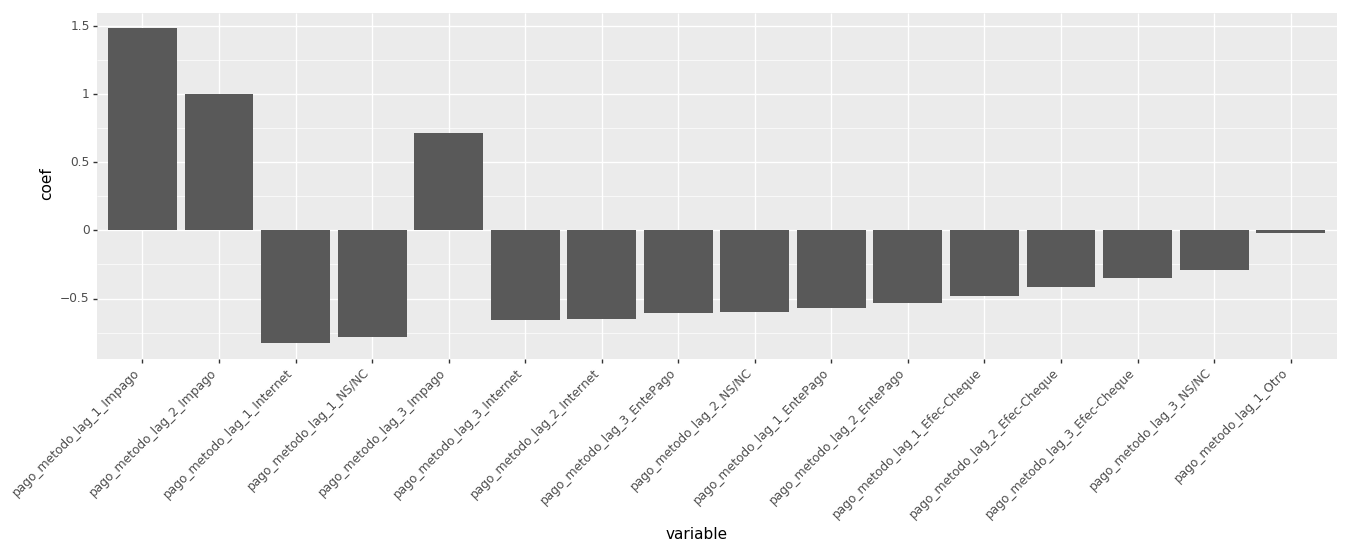

<ggplot: (-9223371915306233740)>

In [133]:
get_logReg_coef(logReg, X_train.columns)